## Study Laquitaine & Gardner human motion direction estimation errors

author: steeve.laquitaine@epfl.ch

Inpired from [Laquitaine & Gardner, Neuron, 2018](https://doi.org/10.1016/j.neuron.2017.12.011)

## Project Functions

### Imports & Consts

In [1]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy
import warnings
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression

%matplotlib inline
warnings.filterwarnings("ignore")


### Data dictionary

`data` contains sessions from 12 human subjects, data from [Laquitaine & Gardner, 2018](https://doi.org/10.1016/j.neuron.2017.12.011).

Subjects had to estimate the direction of stimulus motion directions.

* `data['trial_index']`: trial index
* `data['trial_time']`: time at which trial starts with th e central fixation dot
* `data['response_arrow_start_angle']`: the angle of the response arrow at the start of the response phase.
* `data['motion_direction']`: the stimulus motion direction
* `data['motion_coherence']`: the stimulus motion coherence
* `data['estimate_x']`: x cartesian coordinate of the stimulus motion direction
* `data['estimate_y']`: y cartesian coordinate of the stimulus motion direction
* `data['reaction_time']`: subject's reaction time
* `data['raw_response_time']`: subject response time since the start of the run (of about 200 trials)
* `data['prior_std']`: It is the standard deviation of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['prior_mean']`: the most frequently displayed motion direction. It is the mean of the statistical distribution (motion direction generative process over trials, which we call "experimental prior") from which we sampled the stimulus motion direction displayed in each trial.
* `data['subject_id']`: the id of the subject for which behavior was recorded.
* `data['experiment_name']`: the name of the experiment. This dataaset only contains the "data01_direction4priors" experiment in which subject underwent a task in which four motion direction were sampled from one of four priors with 10, 40, 60 and 80 degree standard deviations in each block of about 200 trials. The mean of the "experimental prior"  was fixed at 225 deg.
* `data['experiment_id']`: the id of the experiment.
* `data['session_id']`: the id of the session.
* `data['run_id']`: the id of the run.


The complete original dataset is stored in .mat files here: https://data.mendeley.com/datasets/nxkvtrj9ps/1.

### Utils

In [2]:
def classifying_choice(est_deg: float, true_direction: int, filerting_window: int = 45, prior_mean: int = 225) -> int:
    """
    Returns 0 if subject chooses prior mean direction; 1 if subject chooses true direction and -1 otherwise.
    """
    if true_direction == prior_mean:
        return -2
    if (min(np.abs(true_direction - est_deg), 360 - np.abs(true_direction - est_deg))) < filerting_window and (min(np.abs(prior_mean - est_deg), 360 - np.abs(prior_mean - est_deg))) < filerting_window:
        if (min(np.abs(true_direction - est_deg), 360 - np.abs(true_direction - est_deg))) < (min(np.abs(prior_mean - est_deg), 360 - np.abs(prior_mean - est_deg))):
            return 1
        return 0
    if (min(np.abs(true_direction - est_deg), 360 - np.abs(true_direction - est_deg))) < filerting_window:
        return 1
    if (min(np.abs(prior_mean - est_deg), 360 - np.abs(prior_mean - est_deg))) < filerting_window:
        return 0
    return -1

In [3]:
def calculating_error_angle(est_deg: float, true_direction: int, choice: int, prior_mean: int = 225) -> float:
    """
    Returns difference in cartesian angles between subject's estimation and true direction (or prior mean depending on subject's choice).
    """
    if choice == -1 or choice == -2:
        return -1
    if choice == 1:
        true_deg = true_direction
    if choice == 0:
        true_deg = prior_mean
    if est_deg > true_deg and est_deg - true_deg < 180:
        return -(est_deg - true_deg)
    if est_deg > true_deg and est_deg - true_deg > 180:
        return 360 - est_deg + true_deg
    if est_deg < true_deg and true_deg - est_deg < 180:
        return (true_deg - est_deg)
    if est_deg < true_deg and - est_deg + true_deg > 180:
        return true_deg - est_deg - 360

In [4]:
def count_classes_in_window(window):
    return window.value_counts()

In [5]:
def plot_dynamics(data: pd.DataFrame, subject_id: int, run_id: int, std_dev: int, absolute_values: bool = True, sliding_window: int = 80, step: int = 10):
    """
    Plots dynamics of subject's choices over time for particular run.
    """
    data = data[data["subject_id"] == subject_id][data["run_id"] == run_id]
    prior_mean_choices = []
    true_direction_choices = []
    labels = []
    for i in range(0, len(data), step):
        if i+sliding_window < len(data):
            window = data.iloc[i:i+sliding_window]
            window = window["choice"]
            num_classes = count_classes_in_window(window)
            labels.append((i + i+sliding_window)//2)
            # if flag and num_classes[1]
            try:
               prior_mean_choices.append((num_classes[0])/(num_classes[0] + num_classes[1]))
            except KeyError:
               prior_mean_choices.append(0)
            try:
               true_direction_choices.append((num_classes[1])/(num_classes[0] + num_classes[1]))
            except KeyError:
               true_direction_choices.append(0)

    fig = go.Figure()
    if absolute_values:
        fig.add_trace(go.Scatter(x = labels, y = prior_mean_choices, name = "# of Prior Mean Choices", mode = "lines+markers"))
        fig.add_trace(go.Scatter(x = labels, y = true_direction_choices, name = "# of True Direction Choices", mode = "lines+markers"))
        fig.update_layout(title = f"Dynamics of Choices Over Time For Subject {subject_id} With Standard Deviation {std_dev}", xaxis_title = "Window Mean Position", yaxis_title = "Number of Choices")
    else:
        fig.add_trace(go.Scatter(x = labels, y = [100*x for x in prior_mean_choices], name = "% of Prior Mean Choices", mode = "lines+markers"))
        fig.add_trace(go.Scatter(x = labels, y = [100*x for x in true_direction_choices], name = "% of True Direction Choices", mode = "lines+markers"))
        fig.update_layout(title = f"Dynamics of Choices Over Time For Subject {subject_id} With Standard Deviation {std_dev}", xaxis_title = "Window Mean Position", yaxis_title = "Relative Number of Choices (in %)")
    fig.show()
    # return fig

In [6]:
def plot_variances(data: pd.DataFrame, subject_id: int, sliding_window: int = 80, step: int = 10):
    """
    Plots dynamics of subject's choices variances over time for all runs.
    """
    run_ids = list(data[data['subject_id'] == subject_id]['run_id'].unique())
    prior_variances = []
    true_direction_variances = []
    x_labels = []
    labels = []
    for index, run_id in enumerate(run_ids):
        data_run = data[data["subject_id"] == subject_id][data["run_id"] == run_id]
        prior_mean_choices = []
        true_direction_choices = []
        for i in range(0, len(data_run), step):
            if i+sliding_window < len(data_run):
                window = data_run.iloc[i:i+sliding_window]
                window = window["choice"]
                num_classes = count_classes_in_window(window)
            # if flag and num_classes[1]
                try:
                    prior_mean_choices.append(100*(num_classes[0])/(num_classes[0] + num_classes[1]))
                except KeyError:
                    prior_mean_choices.append(0)
                try:
                    true_direction_choices.append(100*(num_classes[1])/(num_classes[0] + num_classes[1]))
                except KeyError:
                    true_direction_choices.append(0)
        labels.append(f'rgb({",".join(COLORS[list(data[data["subject_id"] == subject_id][data["run_id"] == run_id]["prior_std"].unique())[0]].astype(str))})')
        x_labels.append(index)
        prior_variances.append(np.std(prior_mean_choices))
        true_direction_variances.append(np.std(true_direction_choices))

    # print(prior_variances)
    # print(true_direction_variances)
    # print(x_labels)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = x_labels, y = prior_variances, marker_color = labels, name = "Variance of Prior Mean Choices", mode = "lines+markers"))
    # fig.add_trace(go.Scatter(x = x_labels, y = true_direction_variances, marker_color = labels, name = "Vairance of True Direction Choices", mode = "lines+markers"))
    fig.update_layout(title = f"Dynamics of Standard Deviation of Choices Over Time For Subject {subject_id}", xaxis_title = "Run #", yaxis_title = "Standard Deviation of Number of Choices")
    fig.show()

In [7]:
def split_df(df):
    if len(df) % 2 != 0:  # Handling `df` with `odd` number of rows
        df = df.iloc[:-1, :]
    df1, df2 =  np.array_split(df, 2)
    return df1, df2

In [8]:
def middle_run_variance_prior_strength(data: pd.DataFrame, prior_strength: int, sliding_window: int = 80, step: int = 10):
    """
    Plots dynamics of subject's choices variances over time for all runs.
    """
    run_ids = list(data[data['prior_std'] == prior_strength]['run_id'].unique())
    first_half_variances = []
    second_half_variances = []
    for run_id in run_ids:
        data_run = data[data["prior_std"] == prior_strength][data["run_id"] == run_id]
        prior_mean_choices = []
        for i in range(0, len(data_run), step):
            if i+sliding_window < len(data_run):
                window = data_run.iloc[i:i+sliding_window]
                window = window["choice"]
                num_classes = count_classes_in_window(window)
                try:
                    prior_mean_choices.append(100*(num_classes[0])/(num_classes[0] + num_classes[1]))
                except KeyError:
                    prior_mean_choices.append(0)
        data_run_first_half, data_run_second_half = split_df(data_run)
        # print(data_run_first_half["motion_coherence"].value_counts())
        # print(data_run_second_half["motion_coherence"].value_counts())
        first_half_variances.append(np.std(prior_mean_choices[:len(prior_mean_choices)//2]))
        second_half_variances.append(np.std(prior_mean_choices[len(prior_mean_choices)//2:]))

    print(scipy.stats.ttest_ind(first_half_variances, second_half_variances, equal_var = False))
    fig = go.Figure()
    fig.add_trace(go.Box(y = first_half_variances, name =  "Standard Deviation of First Half of The Runs"))
    fig.add_trace(go.Box(y = second_half_variances, name =  "Standard Deviation of Second Half of The Runs"))
    fig.update_layout(title = f"Comparison of Stds For Prior Std {prior_strength} Over First and Second Halves of The Runs", yaxis_title = "Standard Deviation of Number of Choices")
    fig.show()

In [9]:
def middle_run_variance(data: pd.DataFrame, subject_id: int, sliding_window: int = 80, step: int = 10):
    """
    Plots dynamics of subject's choices variances over time for all runs.
    """
    run_ids = list(data[data['subject_id'] == subject_id]['run_id'].unique())
    first_half_variances = []
    second_half_variances = []
    for run_id in run_ids:
        data_run = data[data["subject_id"] == subject_id][data["run_id"] == run_id]
        prior_mean_choices = []
        for i in range(0, len(data_run), step):
            if i+sliding_window < len(data_run):
                window = data_run.iloc[i:i+sliding_window]
                window = window["choice"]
                num_classes = count_classes_in_window(window)
                try:
                    prior_mean_choices.append(100*(num_classes[0])/(num_classes[0] + num_classes[1]))
                except KeyError:
                    prior_mean_choices.append(0)
        data_run_first_half, data_run_second_half = split_df(data_run)
        # print(data_run_first_half["motion_coherence"].value_counts())
        # print(data_run_second_half["motion_coherence"].value_counts())
        first_half_variances.append(np.std(prior_mean_choices[:len(prior_mean_choices)//2]))
        second_half_variances.append(np.std(prior_mean_choices[len(prior_mean_choices)//2:]))


    fig = go.Figure()
    fig.add_trace(go.Box(y = first_half_variances, name = "Standard Deviation of First Half of The Runs"))
    fig.add_trace(go.Box(y = second_half_variances, name = "Standard Deviation of Second Half of The Runs"))
    fig.update_layout(title = f"Comparison of Standard Deviations For Subject {subject_id} Over First and Second Halves of The Runs", yaxis_title = "Standard Deviation of Number of Choices")
    fig.show()

In [10]:
def dynamics_variance(data: pd.DataFrame, subject_agg: bool, prior_strength_agg: bool, gen_agg: bool, sliding_window: int = 80, step: int = 10):
    """
    Plots dynamics of subject's choices over time for particular run.
    """
    if subject_agg:
        for subject_id in SUBJECT_IDS:
            subject_smallest_diff = []
            subejct_biggest_diff = []
            run_ids = list(data[data['subject_id'] == subject_id]['run_id'].unique())
            for run_id in run_ids:
                data_run = data[data["subject_id"] == subject_id][data["run_id"] == run_id]
                max_val = -100
                min_val = 100
                labels = []
                for i in range(0, len(data_run), step):
                    if i+sliding_window < len(data_run):
                        window = data_run.iloc[i:i+sliding_window]
                        window = window["choice"]
                        num_classes = count_classes_in_window(window)
                        labels.append((i + i+sliding_window)//2)
                    try:
                        max_val = max(100*(num_classes[1] - num_classes[0])/(num_classes[0] + num_classes[1]), max_val)
                        min_val = min(100*(num_classes[1] - num_classes[0])/(num_classes[0] + num_classes[1]), min_val)
                    except KeyError:
                        try:
                            no_zeros = num_classes[0]
                        except KeyError:
                            min_val = -100
                        try:
                            no_ones = num_classes[1]
                        except KeyError:
                            max_val = 100
                subejct_biggest_diff.append(max_val)
                subject_smallest_diff.append(min_val)
            fig = go.Figure()
            fig.add_trace(go.Box(y = subejct_biggest_diff, name = "Biggest difference between subject's choices"))
            fig.add_trace(go.Box(y = subject_smallest_diff, name = "Smallest difference between subject's choices"))
            fig.update_layout(title = f"Boxplots of variances across runs aggregated for subject {subject_id}", yaxis_title = "Variance of Choices")
            fig.show()
    if prior_strength_agg:
        for prior_strength in PRIOR_STRENGTHS:
            subject_smallest_diff = []
            subejct_biggest_diff = []
            run_ids = list(data[data['prior_std'] == prior_strength]['run_id'].unique())
            for run_id in run_ids:
                data_run = data[data["subject_id"] == prior_strength][data["run_id"] == run_id]
                max_val = -100
                min_val = 100
                labels = []
                for i in range(0, len(data_run), step):
                    if i+sliding_window < len(data_run):
                        window = data_run.iloc[i:i+sliding_window]
                        window = window["choice"]
                        num_classes = count_classes_in_window(window)
                        labels.append((i + i+sliding_window)//2)
                    try:
                        max_val = max(100*(num_classes[1] - num_classes[0])/(num_classes[0] + num_classes[1]), max_val)
                        min_val = min(100*(num_classes[1] - num_classes[0])/(num_classes[0] + num_classes[1]), min_val)
                    except KeyError:
                        try:
                            no_zeros = num_classes[0]
                        except KeyError:
                            min_val = -100
                        try:
                            no_ones = num_classes[1]
                        except KeyError:
                            max_val = 100
                subejct_biggest_diff.append(max_val)
                subject_smallest_diff.append(min_val)
            fig = go.Figure()
            fig.add_trace(go.Box(y = subejct_biggest_diff, name = "Biggest difference between choices for fixed prior strength"))
            fig.add_trace(go.Box(y = subject_smallest_diff, name = "Smallest difference between choices for fixed prior strength"))
            fig.update_layout(title = f"Boxplots of variances across runs aggregated for prior strength {prior_strength}", yaxis_title = "Variance of Choices")
            fig.show()


In [11]:
def get_cartesian_to_deg(
    x: np.ndarray, y: np.ndarray, signed: bool
) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree

### Data Processing

In [14]:
# @title Data retrieval

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
  RequestAPI = requests.get(url)
except requests.ConnectionError:
  print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
  if RequestAPI.status_code != requests.codes.ok:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
  else:
    with open("data01_direction4priors.csv", "wb") as fid:
      fid.write(RequestAPI.content)

In [15]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


In [16]:
SUBJECT_IDS = list(data["subject_id"].unique())
PRIOR_STRENGTHS = list(data["prior_std"].unique())
COLORS = {10: np.array([0,.7,.5])*255,
          20: np.array([1,.5,0])*255,
          40: np.array([1,0,0])*255,
          80: np.array([0.7,0,0])*255}

In [17]:
data["estimates_deg"] = np.round(get_cartesian_to_deg(data["estimate_x"].values, data["estimate_y"].values, False))
data['choice'] = data.apply(lambda x: classifying_choice(x.estimates_deg, x.motion_direction), axis=1)
data["error"] = data.apply(lambda x: calculating_error_angle(x.estimates_deg, x.motion_direction, x.choice), axis=1)

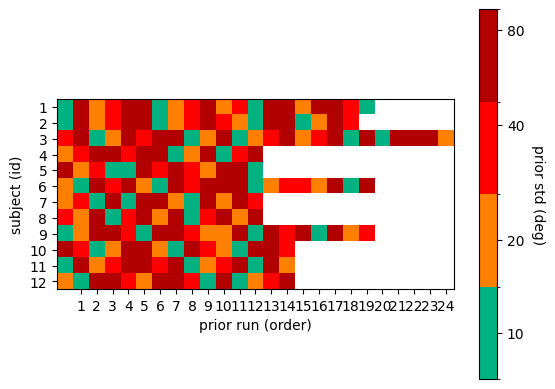

In [18]:
# @title Temporal order of prior runs by subject for the first session
subject_id_set = data["subject_id"].unique()
n_subjects = len(subject_id_set)
prior_runs_all = []
max_nb_runs = 0

# get sequence of prior runs for each subject
for subject_id in subject_id_set:

  # get subject's dataset
  sub01_data = data[(data["subject_id"]==subject_id) & data["session_id"]==1][["subject_id", "trial_index", "session_id", "run_id", "prior_std", "motion_coherence"]]

  # plot the ordering of prior runs
  gp = sub01_data.groupby(["subject_id", "session_id", "run_id", "prior_std"])[["trial_index"]].count()
  prior_runs = gp.reset_index()["prior_std"].values
  prior_runs_all.append(list(prior_runs))
  max_nb_runs = max(max_nb_runs, len(prior_runs))

# create a matrix that contains the sequence of all subjects' prior runs
run_order_matrix = np.zeros((n_subjects, max_nb_runs))*np.nan
for sub_ix, _ in enumerate(subject_id_set):
  run_order_matrix[sub_ix, 0: len(prior_runs_all[sub_ix])] = prior_runs_all[sub_ix]

# init figure
fig, ax = plt.subplots(1,1)

# create custom colormap
cmp = ListedColormap([[0,.7,.5], [1,.5,0], [1,0,0], [0.7,0,0]])

# set colormap bounds
bounds = [5, 15, 25, 45, 90]
norm = colors.BoundaryNorm(bounds, cmp.N)

# plot sequence of prior runs
plt.imshow(run_order_matrix, cmap=cmp, norm=norm)

# setup x legend
ax.set_xticks(np.arange(1, run_order_matrix.shape[1],1))
ax.set_xticklabels(np.arange(1, run_order_matrix.shape[1],1))
ax.set_xlabel("prior run (order)")

# setup y legend
ax.set_yticks(np.arange(0, run_order_matrix.shape[0],1))
ax.set_yticklabels(subject_id_set)
ax.set_ylabel("subject (id)")

# setup colobar
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([10,20,40,80])
cbar.ax.get_yaxis().labelpad = 15;
cbar.ax.set_ylabel('prior std (deg)', rotation=270);

### Data Analysis

#### Estimating translation lapses

Mean = 1.45, std = 15.01
Mean = -0.93, std = 13.96
Mean = -1.76, std = 13.78
Mean = -0.05, std = 16.45
Mean = -2.79, std = 22.47
Mean = -1.41, std = 18.47
Mean = 0.20, std = 16.18
Mean = -0.03, std = 19.44
Mean = 3.00, std = 16.86
Mean = -0.71, std = 18.41
Mean = -1.22, std = 17.05
Mean = -2.22, std = 17.77


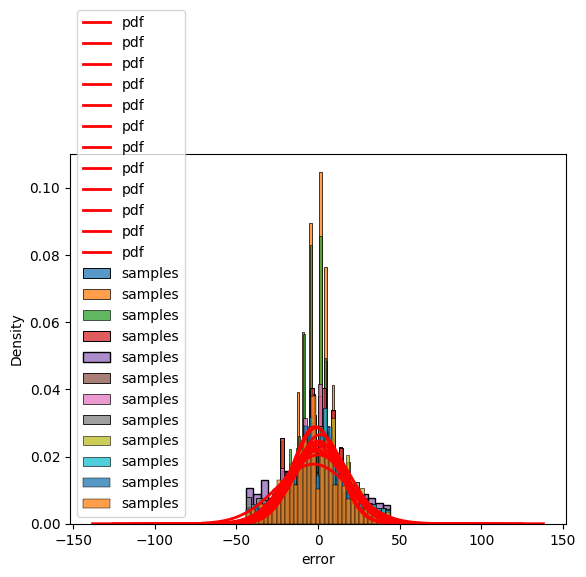

In [19]:
errors = data[data["error"] != -1]
for subject in SUBJECT_IDS:
    errors_sub = errors[errors["subject_id"] == subject]
    mean = errors_sub["error"].mean()
    std = errors_sub["error"].std()
    print(f"Mean = {mean:.02f}, std = {std:.02f}")

    ax = sns.histplot(errors_sub["error"], kde=False, stat='density', label='samples')

    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf, loc = mean, scale = std)

    ax.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')
    ax.legend()

#### Temporal Dynamics Analysis

In [20]:
for prior_strength in PRIOR_STRENGTHS:
    middle_run_variance_prior_strength(data, prior_strength)

Ttest_indResult(statistic=0.4266667282092999, pvalue=0.6710592813014858)


Ttest_indResult(statistic=1.7757823690873926, pvalue=0.0801945260310375)


Ttest_indResult(statistic=-0.24935085072161522, pvalue=0.8038523243960376)


Ttest_indResult(statistic=0.9062933442578431, pvalue=0.3683313509064715)


In [ ]:
for subject_id in SUBJECT_IDS:
    middle_run_variance(data, subject_id)

In [ ]:
for subject_id in SUBJECT_IDS[7:8]:
    run_ids = list(data[data['subject_id'] == subject_id]['run_id'].unique())
    for run_id in run_ids:
       std_dev = list(data[data['subject_id'] == subject_id][data['run_id'] == run_id]['prior_std'].unique())
       plot_dynamics(data, subject_id, run_id, std_dev[0], False)

In [ ]:
dynamics_variance(data, False, True, False)

In [ ]:
for subject_id in SUBJECT_IDS:
    plot_variances(data, subject_id)

### Predictive Modeling

#### Preparing Data for Model

In [21]:
TRAIN_SUBJECTS = [1, 3, 5, 6, 8, 11]
TEST_SUBJECTS = [7, 10, 12]
COLUMNS_OF_INTEREST_WITH_LAGS = ["motion_coherence", "motion_direction", "reaction_time", "estimates_deg"]
COLUMNS_TO_BE_EXCLUDED = ["motion_direction", "reaction_time", "estimates_deg"]
COLUMNS_TO_KEEP = ["motion_coherence", "motion_direction", "reaction_time", "estimates_deg", "prior_std", "choice"]
data_with_reaction_times = data[(~data["reaction_time"].isna())][["motion_coherence", "motion_direction", "reaction_time", "estimates_deg", "prior_std", "choice", "subject_id", "run_id"]]

In [22]:
def prepare_design_matrix(data:pd.DataFrame, subject_ids: list, num_of_lags: int):
    design_matrix = pd.DataFrame()

    for subject_id in subject_ids:
        run_ids = list(data[data['subject_id'] == subject_id]['run_id'].unique())
        for run_id in run_ids:
            data_run = data[(data["subject_id"] == subject_id) & (data["run_id"] == run_id)]
            for column in COLUMNS_OF_INTEREST_WITH_LAGS:
                for lag in range(1, num_of_lags + 1):
                    data_run[f"{column}_{lag}"] = data_run[f"{column}"].shift(lag)
            data_run = data_run.tail(data_run.shape[0] - lag)
            data_run = data_run.drop(COLUMNS_TO_BE_EXCLUDED, axis = 1)
            data_run = data_run[(data_run["choice"] == 0) | (data_run["choice"] == 1)]
            design_matrix = pd.concat([design_matrix, data_run])

    return design_matrix.drop(["choice", "subject_id", "run_id"], axis = 1), design_matrix["choice"]

In [ ]:
X_train, y_train = prepare_design_matrix(data_with_reaction_times, TRAIN_SUBJECTS, 2)
X_test, y_test = prepare_design_matrix(data_with_reaction_times, TEST_SUBJECTS, 2)

In [ ]:
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)

LogisticRegression(penalty=None)

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)

  accuracy = (y == y_pred).mean()

  return accuracy


# Compute train accuracy
train_accuracy = compute_accuracy(X_train, y_train, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")
test_accuracy = compute_accuracy(X_test, y_test, log_reg)
print(f"Accuracy on the testing data: {test_accuracy:.2%}")

Accuracy on the training data: 67.58%
Accuracy on the testing data: 60.91%


#### No Regularization

In [ ]:
test_acc = []
train_acc = []
labels = []
for lag in range(1, 16):
    X_train, y_train = prepare_design_matrix(data_with_reaction_times, TRAIN_SUBJECTS, lag)
    X_test, y_test = prepare_design_matrix(data_with_reaction_times, TEST_SUBJECTS, lag)
    log_reg = LogisticRegression(penalty=None)
    log_reg.fit(X_train, y_train)
    train_accuracy = compute_accuracy(X_train, y_train, log_reg)
    test_accuracy = compute_accuracy(X_test, y_test, log_reg)
    labels.append(lag)
    test_acc.append(test_accuracy*100)
    train_acc.append(train_accuracy*100)

fig = go.Figure()
fig.add_trace(go.Scatter(x = labels, y = train_acc, name = "Training Accuracies", mode = "lines+markers"))
fig.add_trace(go.Scatter(x = labels, y = test_acc, name = "Test Accuracies", mode = "lines+markers"))
fig.update_layout(title = "Accuracy for Different Lag Vales", xaxis_title = "Lag", yaxis_title = "Accuracy (in %)")
fig.show()

#### L1 Regularization

In [ ]:
test_acc = []
train_acc = []
labels = []
for lag in range(1, 16):
    X_train, y_train = prepare_design_matrix(data_with_reaction_times, TRAIN_SUBJECTS, lag)
    X_test, y_test = prepare_design_matrix(data_with_reaction_times, TEST_SUBJECTS, lag)
    log_reg = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    log_reg.fit(X_train, y_train)
    train_accuracy = compute_accuracy(X_train, y_train, log_reg)
    test_accuracy = compute_accuracy(X_test, y_test, log_reg)
    labels.append(lag)
    test_acc.append(test_accuracy*100)
    train_acc.append(train_accuracy*100)

fig = go.Figure()
fig.add_trace(go.Scatter(x = labels, y = train_acc, name = "Training Accuracies", mode = "lines+markers"))
fig.add_trace(go.Scatter(x = labels, y = test_acc, name = "Test Accuracies", mode = "lines+markers"))
fig.update_layout(title = "Accuracy for Different Lag Vales", xaxis_title = "Lag", yaxis_title = "Accuracy (in %)")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = labels, y = train_acc, name = "Training Accuracies", mode = "lines+markers"))
fig.add_trace(go.Scatter(x = labels, y = test_acc, name = "Test Accuracies", mode = "lines+markers"))
fig.update_layout(title = "Accuracy for Different Lag Vales", xaxis_title = "Lag", yaxis_title = "Accuracy (in %)")
fig.show()